In [1]:
library(Seurat)
library(ggplot2)
library(UCell)
library(patchwork)
library(tidyr)
library(dplyr)
library(RColorBrewer)
library(GeneNMF)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
do_download <- TRUE

ddir <- "input"
data.path <- sprintf("%s/Tumor_combination_LY_CG.rds", ddir)

if (do_download) {
  dir.create(ddir)
  options(timeout = 3000)
  download.file("https://figshare.com/ndownloader/files/47742634", destfile = data.path)
}

seu <- readRDS(data.path)

In [25]:
library(rhdf5)
library(SingleCellExperiment)
library(Matrix)
library(scater)

Make_unique <- function(arr) {
  dep_arr <- list()
  dep_idx <- which(duplicated(arr))
  for (idx in dep_idx) {
    item <- arr[idx]
    if (!(item %in% attr(dep_arr, "names"))) {
      dep_arr[item] <- 1
    }
    count <- dep_arr[[item]]
    arr[idx] <- paste0(arr[idx], ".", count)
    dep_arr[[item]] <- dep_arr[[item]] + 1
  }
  return(arr)
}

Load_h5adsc_to_SCE <- function(scpath, raw = TRUE) {
  scmat <- h5read(scpath, "/")
  if (("Raw" %in% attr(scmat$layers, "names")) && raw) {
    cat("** Using raw data...\n")
    if (class(scmat$layers$Raw)[[1]] == "list") {
      cat("** Raw data is a sparse matrix...\n")
      dat <- sparseMatrix(
        i = scmat$layers$Raw$indices[] + 1,
        p = scmat$layers$Raw$indptr[],
        x = as.numeric(scmat$layers$Raw$data[]),
        repr = "C"
      )
    } else {
      cat("** Raw data is a dense matrix...\n")
      dat <- as(scmat$layers$Raw, "dgCMatrix")
    }
    h5ad.var <- scmat$var
  } else {
    cat("** Using processed data...\n")
    X <- scmat$X
    dat <- sparseMatrix(
      i = X$indices[] + 1,
      p = X$indptr[],
      x = as.numeric(X$data[]),
      repr = "C"
    )
    h5ad.var <- scmat$var
  }
  cat("** Core data loaded...\n")
  # generate factors using categories
  var <- list()
  if ("__categories" %in% attr(h5ad.var, "names")) { # old anndata
    for (name in attr(h5ad.var[["__categories"]], "names")) {
      if (length(h5ad.var[[name]]) >= length(h5ad.var[["__categories"]][[name]])) {
        var[[name]] <- factor(h5ad.var[[name]], labels = h5ad.var[["__categories"]][[name]])
      }
    }
  } else {
    for (name in attr(h5ad.var, "names")) {
      if (name != "_index") {
        if (class(var[[name]]) == "list") {
          var[[name]] <- factor(h5ad.var[[name]]$codes,
            labels = h5ad.var[[name]]$categories
          )
        } else {
          var[[name]] <- h5ad.var[[name]]
        }
      } else {
        var[[name]] <- h5ad.var[[name]]
      }
    }
  }
  cat("** Var loaded...\n")
  h5ad.obs <- scmat$obs
  obs <- list()
  if ("__categories" %in% attr(h5ad.obs, "names")) { # old anndata
    for (name in attr(h5ad.obs[["__categories"]], "names")) {
      if (length(h5ad.obs[[name]]) >= length(h5ad.obs[["__categories"]][[name]])) {
        obs[[name]] <- factor(h5ad.obs[[name]], labels = h5ad.obs[["__categories"]][[name]])
      }
    }
  } else { # new anndata
    for (name in attr(h5ad.obs, "names")) {
      if (name != "_index") {
        if (class(h5ad.obs[[name]]) == "list") {
          obs[[name]] <- factor(h5ad.obs[[name]]$codes,
            labels = h5ad.obs[[name]]$categories
          )
        } else {
          obs[[name]] <- h5ad.obs[[name]]
        }
      } else {
        obs[[name]] <- h5ad.obs[[name]]
      }
    }
  }
  # some datasets uses barcodes instead of `_index`
  if (!("_index" %in% attr(h5ad.obs, "names"))) {
    obs$`_index` <- obs$`barcodes`
  }
  obs$`_index` <- Make_unique(obs$`_index`)
  obs_use <- data.frame(
    annotation = obs$annotation,
    batch = obs$batch,
    age = obs$age,
    IHC = obs$IHC,
    cnv_status = obs$cnv_status,
    cnv_score = obs$cnv_score,
    row.names = as.character(obs$`_index`)
  )
  cat("** Obs loaded...\n")
  dims <- c(length(h5ad.var[["_index"]]), length(obs$`_index`))
  dat@Dim <- dims
  dat@Dimnames <- list(
    as.character(h5ad.var[["_index"]]),
    as.character(obs$`_index`)
  )
  cat("** Dims loaded...\n")

  sce <- SingleCellExperiment(
    assays = list(counts = dat),
    rowData = DataFrame(data.frame(var[['_index']])),
    colData = DataFrame(data.frame(obs_use))
  )
  cat("** SCE constructed...\n")

  umap <- as.data.frame(t(scmat$obsm$X_umap))
  colnames(umap) <- c('UMAP-1', 'UMAP-2')
  rownames(umap) <- colnames(sce)
  reducedDim(sce, 'UMAP', withDimnames=TRUE) <- umap
  cat("** UMAP loaded...\n")
  return(sce)
}

In [26]:
sce <- Load_h5adsc_to_SCE("adata-epi-concat-12.17.h5ad", raw = TRUE)

** Using processed data...
** Core data loaded...
** Var loaded...
** Obs loaded...
** Dims loaded...
** SCE constructed...
** UMAP loaded...


In [27]:
library(Seurat)
library(SeuratObject)
seu <- SeuratObject::as.Seurat(x = sce, counts = "counts", data = "counts")

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from UMAP- to UMAP_”


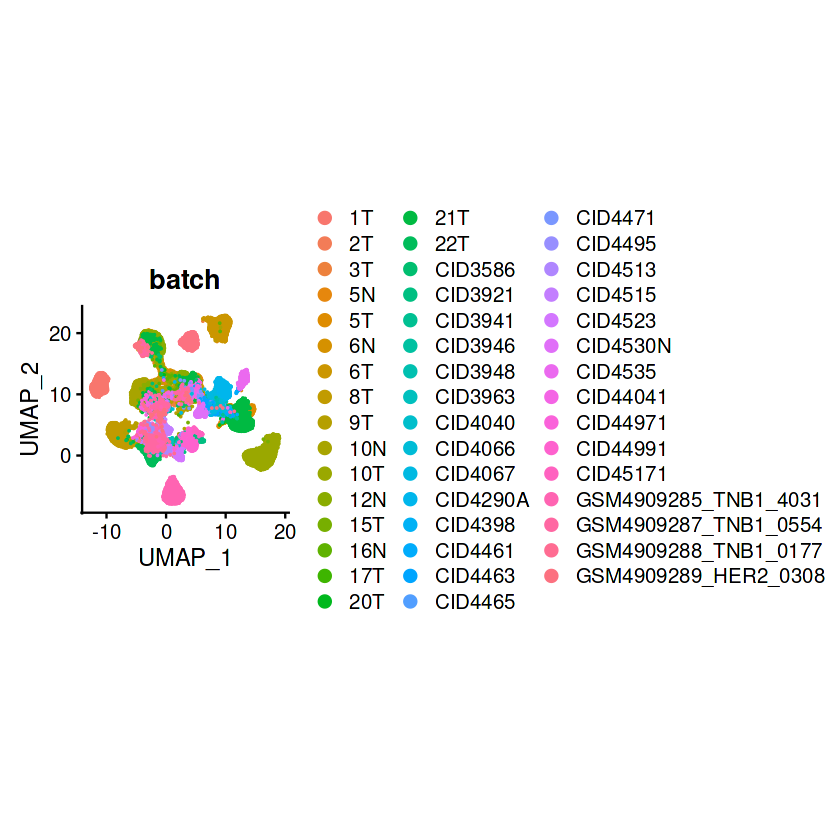

In [209]:
DimPlot(seu, group.by="batch") + theme(aspect.ratio = 1)

In [255]:
seu

An object of class Seurat 
17269 features across 76216 samples within 1 assay 
Active assay: originalexp (17269 features, 0 variable features)
 2 layers present: counts, data
 3 dimensional reductions calculated: UMAP, MPsignatures, umap_MP

In [143]:
seu.list.batch <- SplitObject(seu, split.by = "batch")

In [145]:
seu.list.batch

$`1T`
An object of class Seurat 
17269 features across 2860 samples within 1 assay 
Active assay: originalexp (17269 features, 0 variable features)
 2 layers present: counts, data
 3 dimensional reductions calculated: UMAP, MPsignatures, umap_MP

$`2T`
An object of class Seurat 
17269 features across 2297 samples within 1 assay 
Active assay: originalexp (17269 features, 0 variable features)
 2 layers present: counts, data
 3 dimensional reductions calculated: UMAP, MPsignatures, umap_MP

$`3T`
An object of class Seurat 
17269 features across 4220 samples within 1 assay 
Active assay: originalexp (17269 features, 0 variable features)
 2 layers present: counts, data
 3 dimensional reductions calculated: UMAP, MPsignatures, umap_MP

$`5N`
An object of class Seurat 
17269 features across 4366 samples within 1 assay 
Active assay: originalexp (17269 features, 0 variable features)
 2 layers present: counts, data
 3 dimensional reductions calculated: UMAP, MPsignatures, umap_MP

$`5T`
An obj

In [256]:
attr(seu.list.batch, 'names')

[1] "1T"                   "2T"                   "3T"                  
 [4] "5N"                   "5T"                   "6N"                  
 [7] "6T"                   "8T"                   "9T"                  
[10] "10T"                  "10N"                  "12N"                 
[13] "15T"                  "16N"                  "17T"                 
[16] "20T"                  "21T"                  "22T"                 
[19] "CID44991"             "CID4535"              "CID4067"             
[22] "CID4513"              "CID4515"              "CID4463"             
[25] "CID4523"              "CID4530N"             "CID45171"            
[28] "CID44971"             "CID4066"              "CID3921"             
[31] "CID4471"              "CID4495"              "CID3948"             
[34] "CID4290A"             "CID3586"              "CID4465"             
[37] "CID44041"             "CID3946"              "CID4461"             
[40] "CID3941"              "CID3963"              "CID4040"             
[43] "CID4398"              "GSM4909288_TNB1_0177" "GSM4909287_TNB1_0554"
[46] "GSM4909285_TNB1_4031" "GSM4909289_HER2_0308"

In [262]:
seu.HR <- list(  `5T` = seu.list.batch$`5T`,
                 `6T` = seu.list.batch$`6T`,
                 `10T` = seu.list.batch$`10T`,
                 `15T` = seu.list.batch$`15T`,
                 `20T` = seu.list.batch$`20T`,
                 `21T` = seu.list.batch$`21T`,
                 `22T` = seu.list.batch$`22T`)
# seu.list.TNBC <- SplitObject(seu, split.by = "batch")

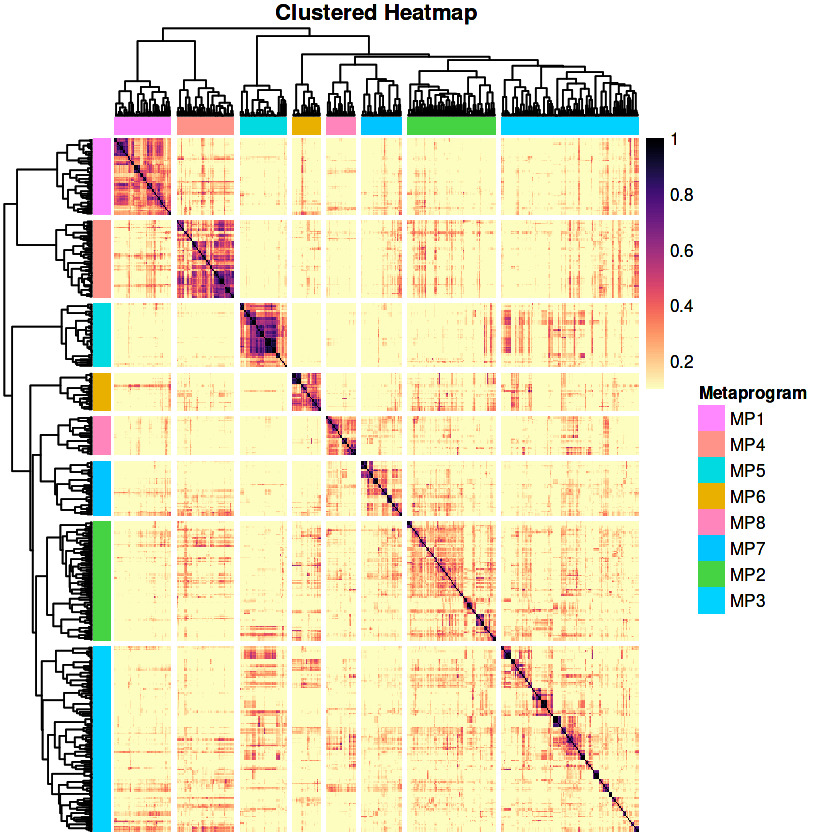

In [ ]:
geneNMF.programs.HR <- multiNMF(seu.HR, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.HR <- getMetaPrograms(geneNMF.programs.HR,
                                        metric = "cosine",
                                        weight.explained = 0.5,
                                        nMP=10)


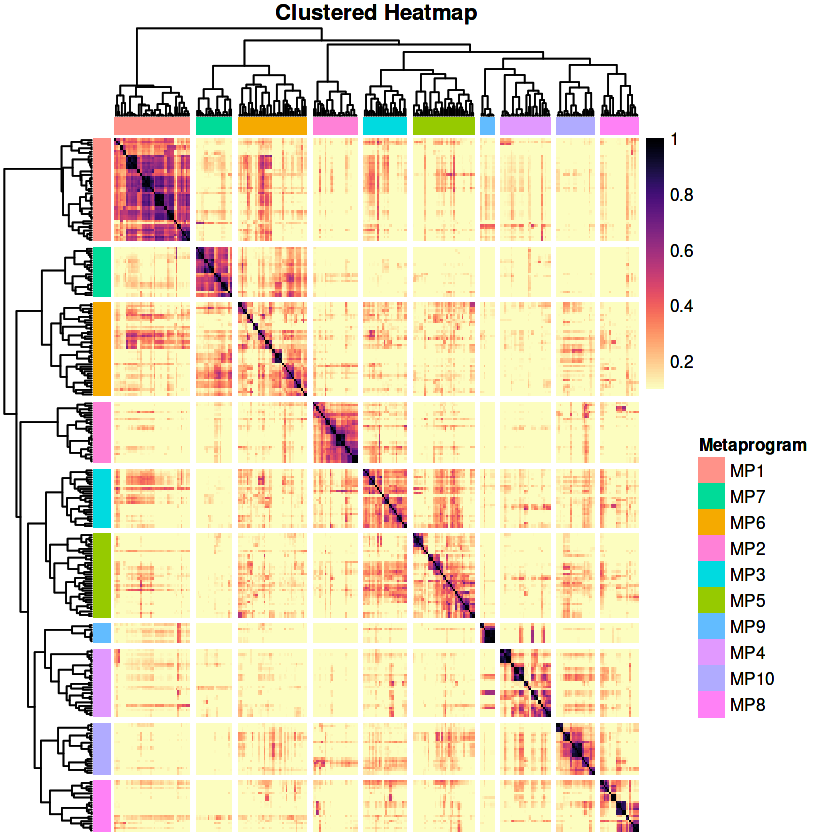

In [285]:
ph <- plotMetaPrograms(geneNMF.metaprograms.HR,
                       similarity.cutoff = c(0.1,1))
ph

In [287]:
svg(filename = "figure-12.9/3e1.svg",width = 7,height = 6.5)
ph
dev.off()

pdf 
  2

In [278]:
top_p.HR <- lapply(geneNMF.metaprograms.HR$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})

In [318]:
for (i in 1:length(geneNMF.metaprograms.TNBC$metaprograms.genes.weights)) {
  fwrite(as.list(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]]), file = paste0("figure-12.9/TableS4.csv"), col.names = T, append = T, quote = F)
}

In [289]:
for (i in 1:length(top_p.HR)) {
  fwrite(top_p.HR[[i]], file = paste0("figure-12.9/TableS6-MP", i, ".csv"), col.names = T, append = F, quote = F)
}

In [265]:
lapply(geneNMF.metaprograms.HR$metaprograms.genes, head)

$MP1
[1] "NR4A1" "ATF3"  "EGR1"  "FOSB"  "RND1"  "TRIB1"

$MP2
[1] "HMGB2"  "STMN1"  "PCNA"   "ANP32E" "DTYMK"  "SMC4"  

$MP3
[1] "ZFP36"   "IER2"    "DNAJB1"  "JUNB"    "LGALS1"  "S100A13"

$MP4
[1] "VIM"     "CD74"    "HLA-DRA" "GSTP1"   "MYL9"    "FBXO32" 

$MP5
[1] "IFI6"  "TFF3"  "TFF1"  "RAMP1" "MX1"   "IFI27"

$MP6
[1] "TRIB1"  "IGFBP5" "FLNB"   "BTG2"   "KLF6"   "BAG3"  

$MP7
[1] "XIST"     "FTX"      "KCNQ1OT1" "PVT1"     "VPS13B"   "MON2"    

$MP8
[1] "S100P"   "KRT15"   "S100A10" "CD24"    "KRT7"    "MYL9"   

$MP9
[1] "MGP"   "AREG"  "NR4A1" "WFDC2" "ATF3"  "EGR1" 

$MP10
[1] "CLU"     "HLA-A"   "CD74"    "HLA-C"   "HLA-DRA" "HLA-B"

In [288]:
geneNMF.metaprograms.HR$metaprograms.genes

$MP1
 [1] "NR4A1"    "ATF3"     "EGR1"     "FOSB"     "RND1"     "TRIB1"   
 [7] "BTG2"     "ZFP36"    "PPP1R15A" "DUSP1"    "RASD1"    "HSPA6"   
[13] "IER2"     "BAG3"     "IER5"     "CSRNP1"   "JUN"      "DNAJB1"  
[19] "SOCS3"    "DNAJB4"   "ZC3H12A"  "KLF2"     "FOS"     

$MP2
 [1] "HMGB2"  "STMN1"  "PCNA"   "ANP32E" "DTYMK"  "SMC4"   "CKS1B"  "MCM7"  
 [9] "ATAD2"  "TMPO"   "KPNA2"  "UBE2S"  "MCM4"   "TUBA1B" "CKS2"   "GINS2" 
[17] "MCM3"   "HMGB3"  "SAC3D1" "DNAJC9" "CMC2"   "RFC2"   "DNAJB1" "RRM1"  
[25] "DUT"    "BAG3"   "TUBB"   "DDX39A" "HSPA1B" "DEK"    "HMGN2"  "TUBA1C"
[33] "TUBB4B" "HSPA1A" "IER2"   "LSM4"   "RANBP1" "PSIP1"  "JUN"    "LGALS1"
[41] "DNMT1"  "BUB3"  

$MP3
  [1] "ZFP36"      "IER2"       "DNAJB1"     "JUNB"       "LGALS1"    
  [6] "S100A13"    "SMIM22"     "GADD45B"    "CRABP2"     "CKS1B"     
 [11] "TFF3"       "JUN"        "ATOX1"      "ROMO1"      "SLC25A5"   
 [16] "LSM4"       "S100A16"    "RAMP1"      "UQCR10"     "ELF3"      
 [21] "KLF2"       "AP2S1"      "ADIRF"      "COMMD6"     "SNRPD2"    
 [26] "DYNLT1"     "S100A6"     "ANKRD37"    "NDUFB4"     "UQCRQ"     
 [31] "NME4"       "SNRPG"      "DBI"        "PHPT1"      "COX7A2"    
 [36] "TUBB"       "PRSS23"     "METRN"      "MYC"        "TIMM8B"    
 [41] "SH3BGRL3"   "SEC61G"     "PPP1R14B"   "CYB5A"      "TUBA1B"    
 [46] "MZT2A"      "TBCA"       "RANBP1"     "MGST1"      "POLR2L"    
 [51] "APRT"       "COX17"      "COX7B"      "CLU"        "TMA7"      
 [56] "OST4"       "CEBPD"      "LAGE3"      "CLDN4"      "HMGN2"     
 [61] "VAMP8"      "HINT1"      "UQCC2"      "DTYMK"      "NDUFA2"    
 [66] "CTXN1"      "NDUFAF3"    "MIEN1"      "COX8A"      "TMSB4X"    
 [71] "MPC2"       "FOS"        "HSPA1B"     "SAC3D1"     "TOMM5"     
 [76] "TSTD1"      "GGCT"       "MRPL41"     "GUK1"       "HIGD2A"    
 [81] "PCNA"       "HES1"       "S100A14"    "BLVRB"      "DUSP1"     
 [86] "CKS2"       "RHOB"       "MZT2B"      "ZNHIT1"     "STARD10"   
 [91] "BAG3"       "HSPA1A"     "S100A10"    "COX6C"      "TFF1"      
 [96] "BST2"       "TIMP1"      "CHCHD10"    "NME2"       "HSPB8"     
[101] "TFPT"       "HSPE1"      "BRK1"       "RBX1"       "NDUFB11"   
[106] "PAFAH1B3"   "FTL"        "MYL9"       "CARHSP1"    "LSM3"      
[111] "SNRNP25"    "SERTAD1"    "WFDC2"      "JUND"       "GSTM3"     
[116] "DNPH1"      "DCXR"       "IER5L"      "PSMB3"      "PYCR1"     
[121] "SNRPF"      "MT2A"       "NENF"       "TCEAL3"     "EEF1A2"    
[126] "GADD45GIP1" "TMEM258"    "IGFBP2"     "MSRB2"      "HCFC1R1"   
[131] "EEF1B2"     "PRDX5"      "IFITM3"     "TOMM7"      "CSTB"      
[136] "S100A11"    "EVA1B"      "CRIP2"      "SRM"        "TPI1"      
[141] "DDIT3"      "LY6E"       "NUPR1"      "ALDOA"      "SUB1"      
[146] "TST"        "MRPS21"     "SMDT1"      "NDUFA4"     "TRAPPC1"   
[151] "DUT"        "SSR4"      

$MP4
 [1] "VIM"      "CD74"     "HLA-DRA"  "GSTP1"    "MYL9"     "FBXO32"  
 [7] "DST"      "MT1X"     "LGALS1"   "MGP"      "COL1A1"   "ZFP36"   
[13] "EGR1"     "ATF3"     "CNN2"     "GSN"      "PHLDA1"   "HLA-A"   
[19] "IFITM1"   "JUNB"     "FLNA"     "IER2"     "PALLD"    "FOSB"    
[25] "DUSP1"    "JUN"      "BTG2"     "FOS"      "PNRC1"    "PPP1R15A"

$MP5
 [1] "IFI6"     "TFF3"     "TFF1"     "RAMP1"    "MX1"      "IFI27"   
 [7] "IFITM1"   "ISG15"    "TSPAN1"   "BST2"     "IGFBP2"   "HLA-A"   
[13] "HLA-B"    "DUSP1"    "AZGP1"    "NUCB2"    "PRSS23"   "FOS"     
[19] "BTG2"     "LGALS3BP" "JUNB"     "RASD1"    "CST3"     "IER2"    
[25] "LY6E"     "DNAJB1"   "SSR4"     "DEGS2"    "PREX1"    "TIMP1"   
[31] "TMEM59"   "ZFP36"    "AGR2"     "HLA-C"    "CRABP2"   "JUN"     
[37] "EVA1B"    "MIEN1"    "AKR7A3"   "IFITM3"   "LGALS1"   "COX6C"   
[43] "GUK1"     "HSPA1A"   "STARD10"  "S100A6"   "TMSB4X"   "NQO1"    
[49] "POLR2L"  

$MP6
  [1] "TRIB1"    "IGFBP5"   "FLNB"     "BTG2"     "KLF6"     "BAG3"    
  [7] "CCNL1"    "MCL1"     "PLEC"     "JUN"      "HSPH1"    "HLA-A"   
 [13] "PPP1R15A" "MACF1"    "HLA-B"    

In [266]:
geneNMF.metaprograms.HR$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,1.0000000,0.37850500,0.505,23,44
MP2,0.8571429,0.33668780,0.446,42,26
MP3,0.7142857,0.17634459,0.364,152,25
MP4,0.7142857,0.14465929,0.325,30,29
MP5,0.7142857,0.07712165,0.270,49,36
MP6,0.7142857,-0.01789591,0.252,123,40
MP7,0.5714286,0.42073692,0.542,98,21
MP8,0.5714286,0.18790885,0.323,55,22
MP9,0.2857143,0.63295901,0.690,17,8


In [ ]:
seu.TNBC <- list(`1T` = seu.list.batch$`1T`,
                 `2T` = seu.list.batch$`2T`,
                 `3T` = seu.list.batch$`3T`,
                 `8T` = seu.list.batch$`8T`,
                 `9T` = seu.list.batch$`9T`,
                 )

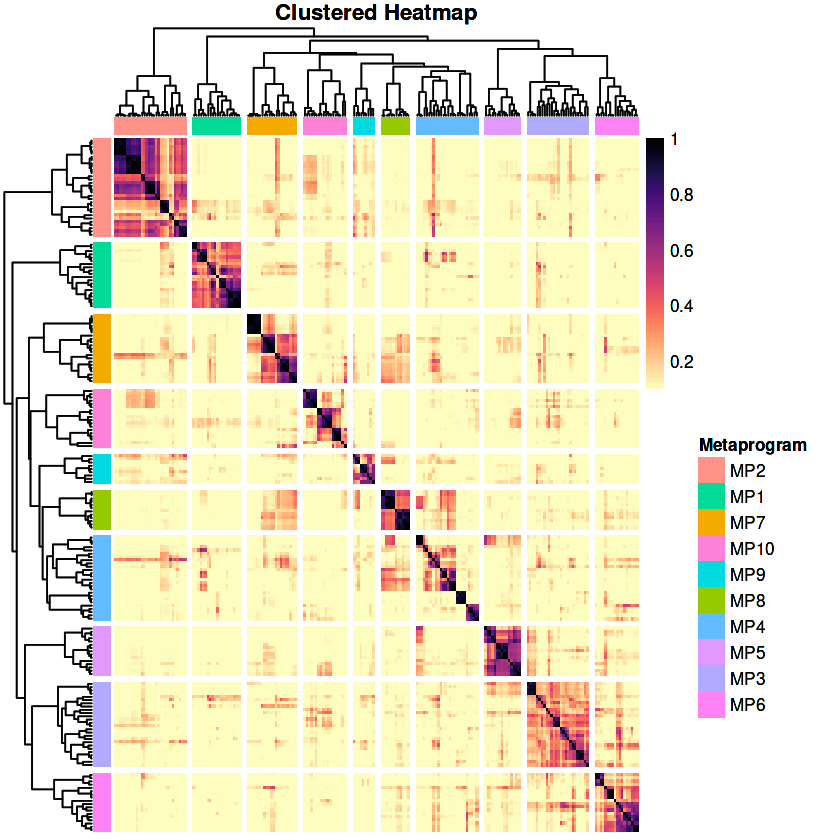

In [150]:
geneNMF.programs.TNBC <- multiNMF(seu.TNBC, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.TNBC <- getMetaPrograms(geneNMF.programs.TNBC,
                                        metric = "cosine",
                                        weight.explained = 0.5,
                                        nMP=8)
ph <- plotMetaPrograms(geneNMF.metaprograms.TNBC,
                       similarity.cutoff = c(0.1,1))
ph

In [213]:
svg(filename = "figure-12.9/3e.svg")
ph
dev.off()

pdf 
  2

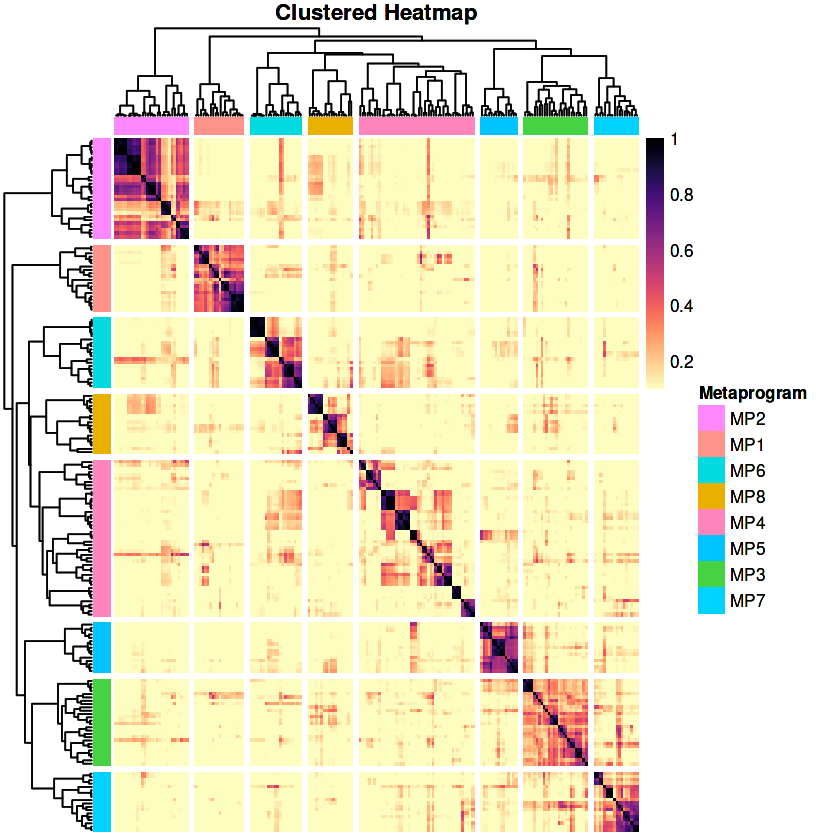

In [163]:
geneNMF.metaprograms.TNBC <- getMetaPrograms(geneNMF.programs.TNBC,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7)
ph <- plotMetaPrograms(geneNMF.metaprograms.TNBC,
                       similarity.cutoff = c(0.1,1))
ph

In [164]:
geneNMF.metaprograms.TNBC$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,1.0,0.44541733,0.499,16,20
MP2,1.0,0.42076821,0.496,14,30
MP3,1.0,0.19380602,0.349,48,26
MP4,1.0,0.04808051,0.196,3,47
MP5,0.8,0.53132572,0.593,72,15
MP6,0.6,0.32710034,0.419,19,21
MP7,0.6,0.29442522,0.406,19,18
MP8,0.2,0.25422386,0.350,45,18


In [165]:
lapply(geneNMF.metaprograms.TNBC$metaprograms.genes, head)

$MP1
[1] "UBE2C"  "CENPF"  "MAD2L1" "CENPW"  "TK1"    "UBE2T" 

$MP2
[1] "MYLK"  "TAGLN" "MYL9"  "ACTA2" "ACTG2" "TPM2" 

$MP3
[1] "XIST"     "FTX"      "NEAT1"    "INTS6"    "VMP1"     "KCNQ1OT1"

$MP4
[1] "CRYAB"  "SLPI"   "CHI3L2"

$MP5
[1] "STC2"     "ANKRD30A" "AR"       "CAMK2N1"  "MAGED2"   "IGFBP4"  

$MP6
[1] "FDCSP"  "IGFBP7" "COL1A2" "COL1A1" "IFI27"  "LTF"   

$MP7
[1] "FOS"   "EGR1"  "IER2"  "DUSP1" "FOSB"  "ATF3" 

$MP8
[1] "TMEM45A" "CSTA"    "CXCL14"  "IFI27"   "LY6D"    "SDC1"

In [225]:
for (i in 1:length(geneNMF.metaprograms.TNBC$metaprograms.genes.weights)) {
  write.table(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]], "figure-12.9/TableS4.csv",col.names = T, append = T, quote = F)
}

Warning message in write.table(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]], :
“appending column names to file”
Warning message in write.table(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]], :
“appending column names to file”
Warning message in write.table(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]], :
“appending column names to file”
Warning message in write.table(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]], :
“appending column names to file”
Warning message in write.table(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]], :
“appending column names to file”
Warning message in write.table(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]], :
“appending column names to file”
Warning message in write.table(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]], :
“appending column names to file”
Warning message in write.table(geneNMF.metaprograms.TNBC$metaprograms.genes.weights[[i]], :
“appending column names to file”


In [166]:
top_p <- lapply(geneNMF.metaprograms.TNBC$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "H")
})

In [231]:
library(data.table)
for (i in 1:length(top_p)) {
  fwrite(top_p[[i]], file = paste0("figure-12.9/TableS5-MP", i, ".csv"), col.names = T, append = F, quote = F)
}

In [178]:
seu.young.TNBC <- subset(seu, subset = batch %in% c("1T", "2T", "3T" , "8T", "9T"))

In [179]:
seu.young.TNBC

An object of class Seurat 
17269 features across 16769 samples within 1 assay 
Active assay: originalexp (17269 features, 0 variable features)
 2 layers present: counts, data
 3 dimensional reductions calculated: UMAP, MPsignatures, umap_MP

In [180]:
mp.genes <- geneNMF.metaprograms.TNBC$metaprograms.genes
seu.young.TNBC <- AddModuleScore_UCell(seu.young.TNBC, features = mp.genes, ncores=4, name = "")

In [196]:
matrix <- seu.young.TNBC@meta.data[,names(mp.genes)]

#dimred <- scale(matrix)
dimred <- as.matrix(matrix)

colnames(dimred) <- paste0("MP_",seq(1, ncol(dimred)))
#New dim reduction
seu.young.TNBC@reductions[["MPsignatures"]] <- new("DimReduc",
                                         cell.embeddings = dimred,
                                         assay.used = "RNA",
                                         key = "MP_",
                                         global = FALSE)
set.seed(123)
seu.young.TNBC <- RunUMAP(seu.young.TNBC, reduction="MPsignatures", dims=1:length(seu.young.TNBC@reductions[["MPsignatures"]]),
               metric = "cosine", reduction.name = "umap_MP")

06:52:40 UMAP embedding parameters a = 0.9922 b = 1.112

06:52:40 Read 16769 rows and found 8 numeric columns

06:52:40 Using Annoy for neighbor search, n_neighbors = 30

06:52:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

06:52:43 Writing NN index file to temp file /tmp/RtmpAXygNS/file3550db1848abf8

06:52:43 Searching Annoy index using 1 thread, search_k = 3000

06:52:50 Annoy recall = 100%

06:52:52 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

06:52:57 Initializing from normalized Laplacian + noise (using RSpectra)

06:52:57 Commencing optimization for 200 epochs, with 660438 positive edges

06:53:11 Optimization finished

Warning message:
“Adding a dimensional reduction (umap_MP) without the associated assay being pr

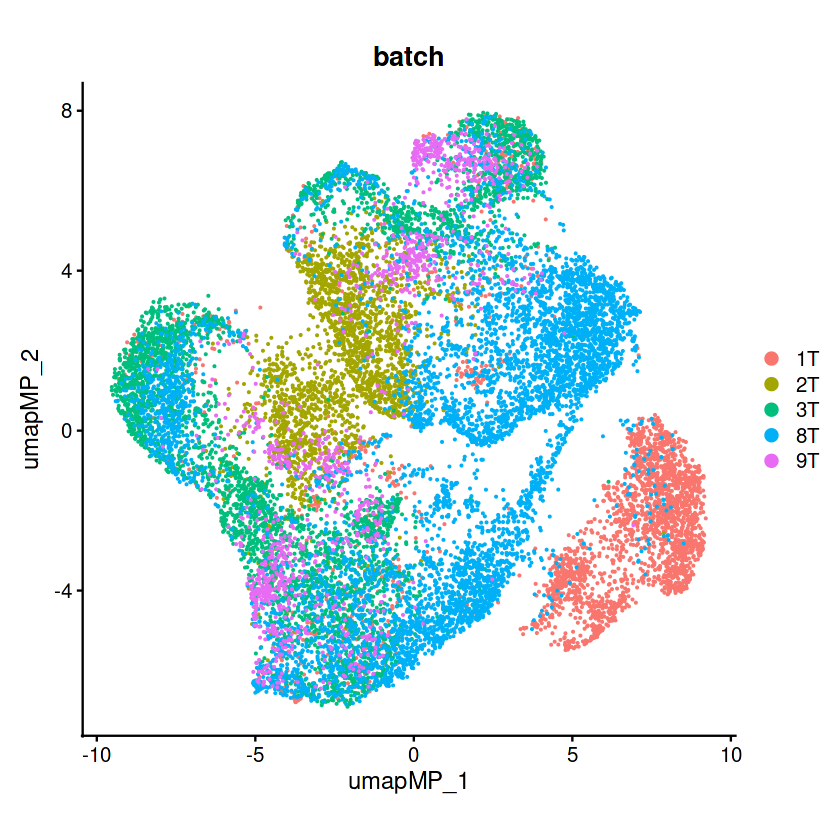

In [254]:
DimPlot(seu.young.TNBC, reduction = "umap_MP", group.by = "batch") + theme(aspect.ratio = 1)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


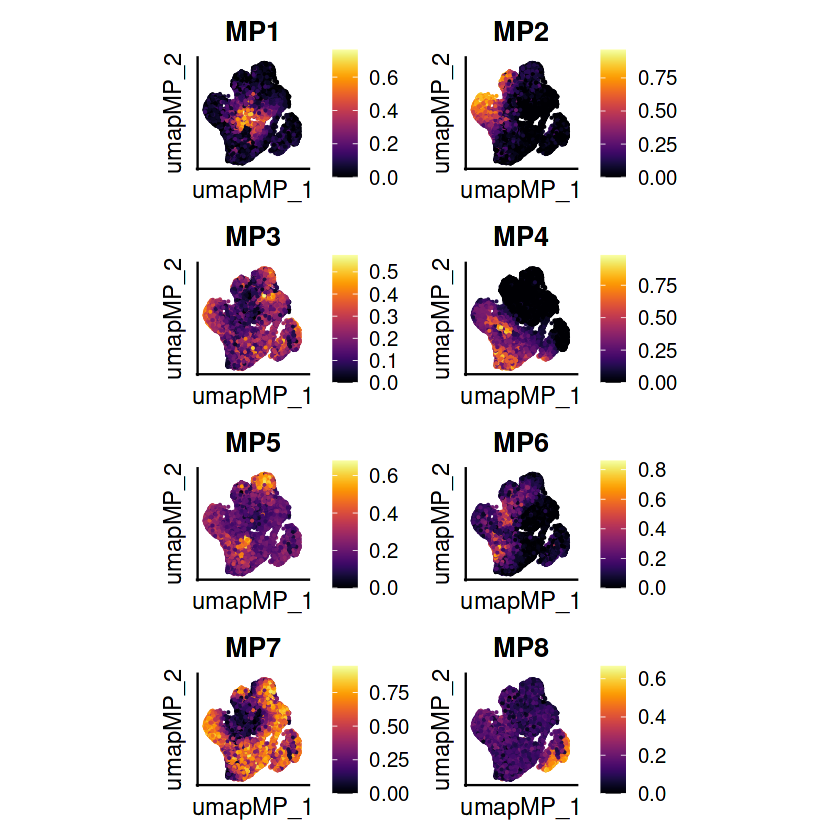

In [253]:
FeaturePlot(seu.young.TNBC, features = names(mp.genes), reduction = "umap_MP", ncol=2) &
  scale_color_viridis(option="B") &
   theme(aspect.ratio = 1, axis.text=element_blank(), axis.ticks=element_blank())

In [249]:
seu <- AddModuleScore_UCell(seu, features = mp.genes, ncores=4, name = "")

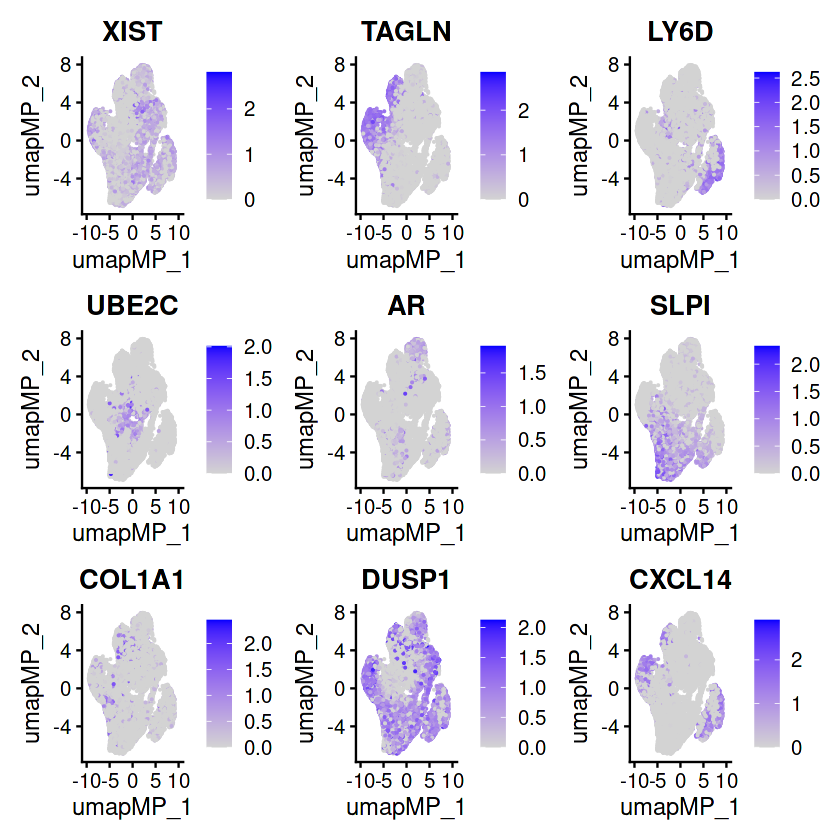

In [212]:
FeaturePlot(seu.young.TNBC, features = c('XIST', 'TAGLN', 'LY6D','UBE2C', 'AR', 'SLPI','COL1A1', 'DUSP1', 'CXCL14'), reduction = "umap_MP", ncol=3)

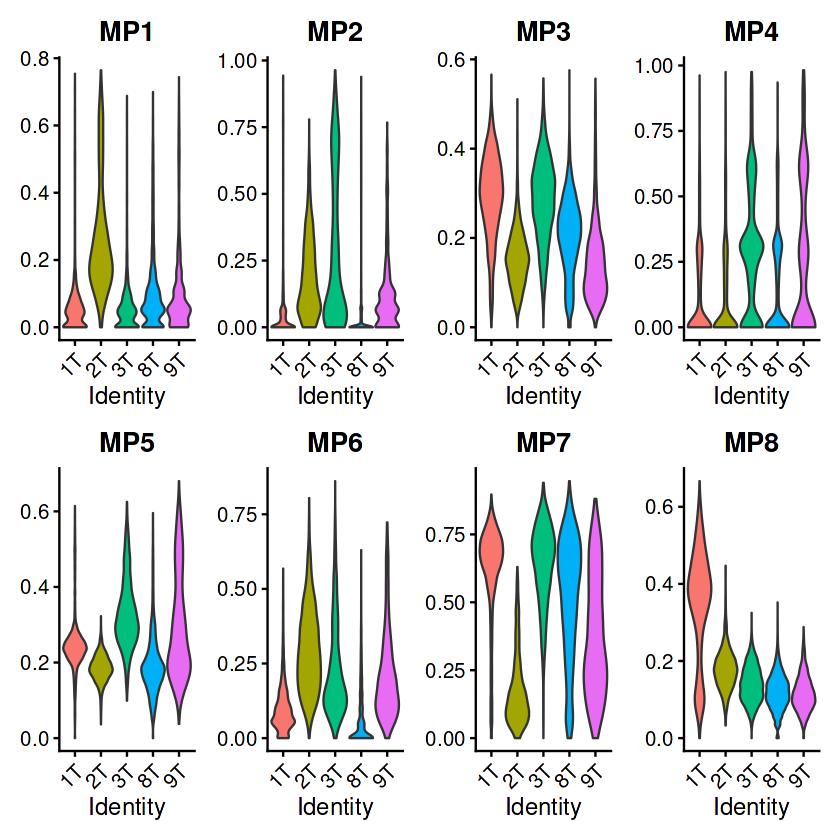

In [242]:
VlnPlot(seu.young.TNBC, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=4)

In [246]:
seu.young.TNBC <- FindNeighbors(seu.young.TNBC, dims=1:8,reduction = "MPsignatures", graph.name = "graph_MP")
seu.young.TNBC <- FindClusters(seu.young.TNBC, resolution = 0.3, graph.name = "graph_MP", cluster.name = 'cluster_MP')

Computing nearest neighbor graph



Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16769
Number of edges: 158444

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9140
Number of communities: 11
Elapsed time: 1 seconds


2 singletons identified. 9 final clusters.



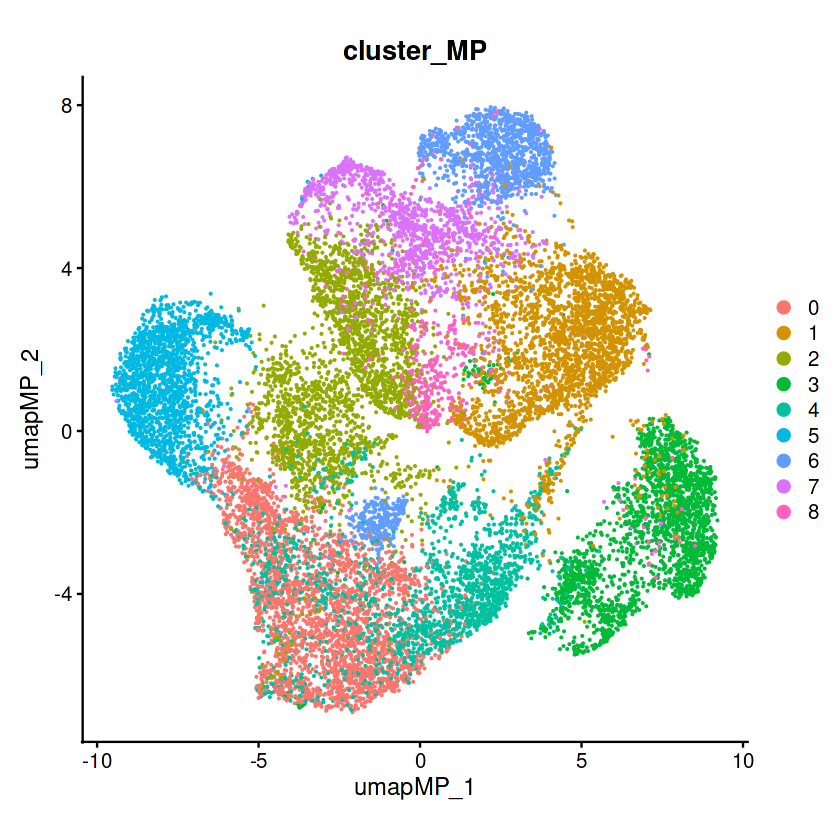

In [247]:
DimPlot(seu.young.TNBC, reduction = "umap_MP", group.by = "cluster_MP") + theme(aspect.ratio = 1)

In [ ]:
DefaultAssay(seu) <- "RNA"
# seu.list <- SplitObject(seu, split.by = "Sample")

# geneNMF.programs <- multiNMF(seu.list, assay="RNA", k=4:9, min.exp = 0.05)

In [39]:
geneNMF.programs <- multiNMF(seu.list, assay="originalexp", k=4:9, min.exp = 0.05)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”


In [43]:
geneNMF.metaprograms <- getMetaPrograms(geneNMF.programs,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=10,
                                        min.confidence = 0.7)

In [13]:
library(msigdbr)
library(fgsea)

In [129]:
seu.TNBC <- FindNeighbors(seu.TNBC, dims=1:8,reduction = "MPsignatures", graph.name = "graph_MP")

Computing nearest neighbor graph



Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



In [131]:
seu.TNBC <- FindClusters(seu.TNBC, resolution = 0.5, graph.name = "graph_MP", cluster.name = 'cluster_MP')

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 20945
Number of edges: 199108

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9170
Number of communities: 19
Elapsed time: 1 seconds


4 singletons identified. 15 final clusters.



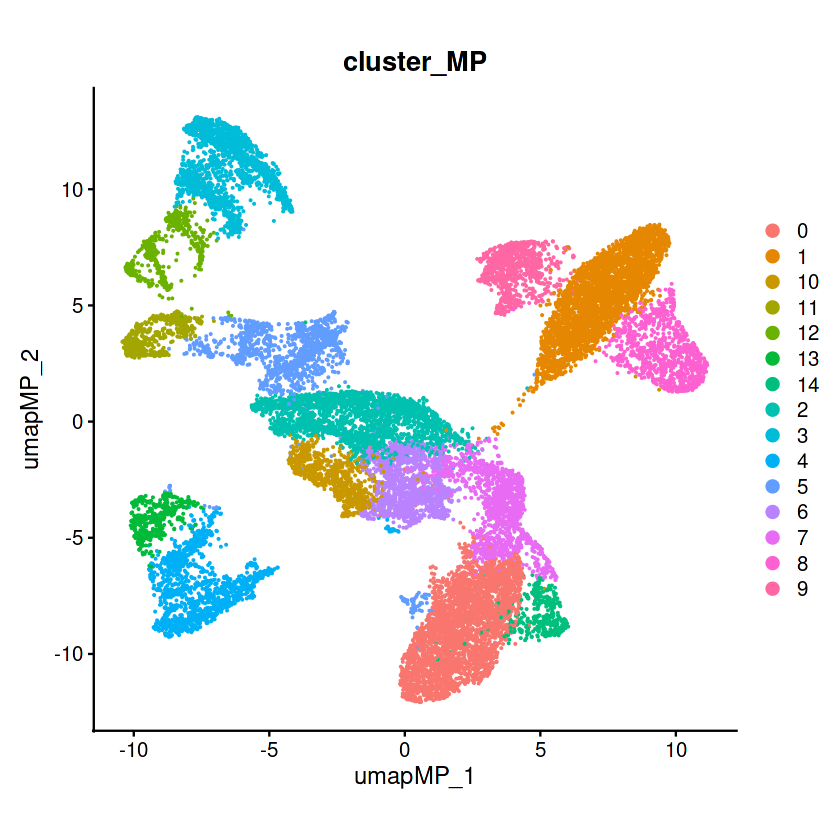

In [132]:
DimPlot(seu.TNBC, reduction = "umap_MP", group.by = "cluster_MP") + theme(aspect.ratio = 1)

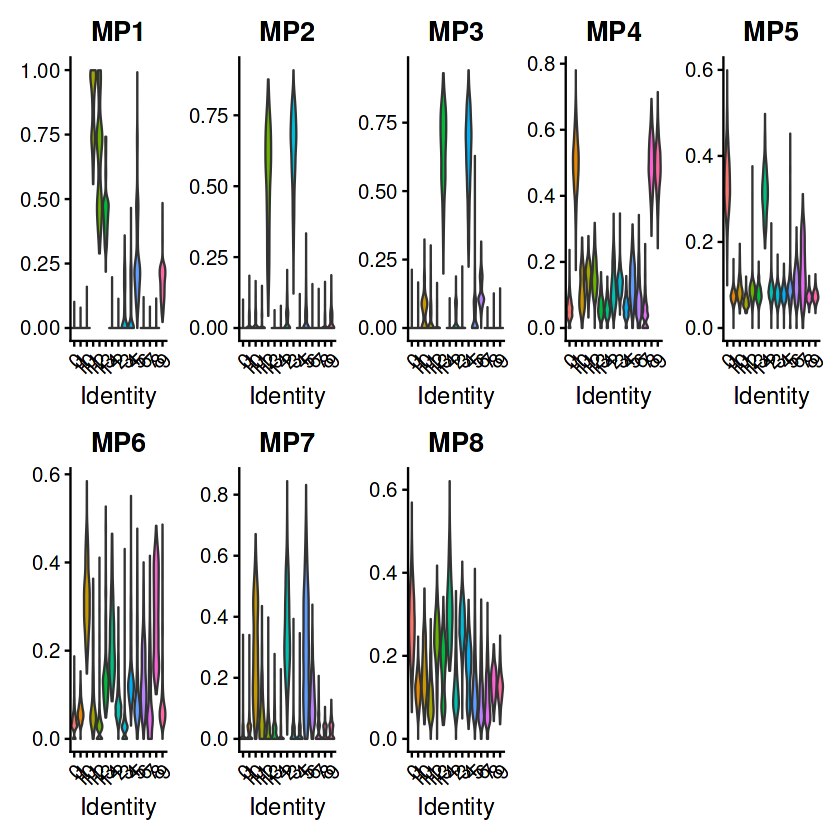

In [136]:
mp.genes <- geneNMF.metaprograms.TNBC$metaprograms.genes
seu.TNBC <- AddModuleScore_UCell(seu.TNBC, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.TNBC, features=names(mp.genes), group.by = "cluster_MP",
        pt.size = 0, ncol=5)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


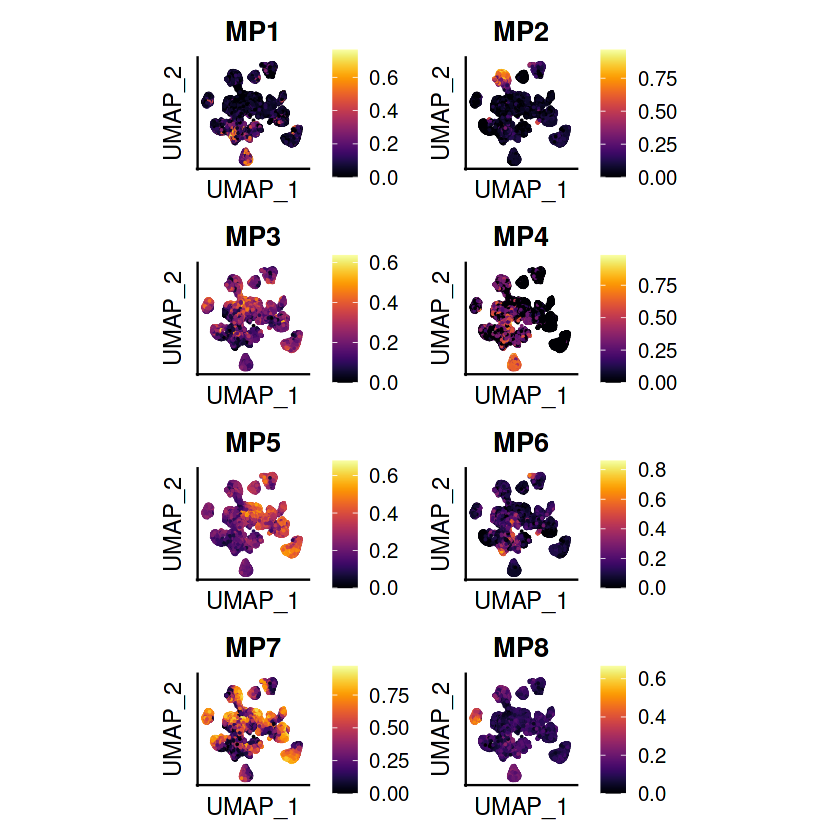

In [251]:
library(viridis)
FeaturePlot(seu, features = names(mp.genes), reduction = "UMAP", ncol=2) &
  scale_color_viridis(option="B") &
   theme(aspect.ratio = 1, axis.text=element_blank(), axis.ticks=element_blank())

In [23]:
library(rhdf5)
library(SingleCellExperiment)
library(Matrix)
library(scater)

Make_unique <- function(arr) {
  dep_arr <- list()
  dep_idx <- which(duplicated(arr))
  for (idx in dep_idx) {
    item <- arr[idx]
    if (!(item %in% attr(dep_arr, "names"))) {
      dep_arr[item] <- 1
    }
    count <- dep_arr[[item]]
    arr[idx] <- paste0(arr[idx], ".", count)
    dep_arr[[item]] <- dep_arr[[item]] + 1
  }
  return(arr)
}

Load_h5adsc_to_SCE <- function(scpath, raw = TRUE) {
  scmat <- h5read(scpath, "/")
  if (("Raw" %in% attr(scmat$layers, "names")) && raw) {
    cat("** Using raw data...\n")
    if (class(scmat$layers$Raw)[[1]] == "list") {
      cat("** Raw data is a sparse matrix...\n")
      dat <- sparseMatrix(
        i = scmat$layers$Raw$indices[] + 1,
        p = scmat$layers$Raw$indptr[],
        x = as.numeric(scmat$layers$Raw$data[]),
        repr = "C"
      )
    } else {
      cat("** Raw data is a dense matrix...\n")
      dat <- as(scmat$layers$Raw, "dgCMatrix")
    }
    h5ad.var <- scmat$var
  } else {
    cat("** Using processed data...\n")
    X <- scmat$X
    dat <- sparseMatrix(
      i = X$indices[] + 1,
      p = X$indptr[],
      x = as.numeric(X$data[]),
      repr = "C"
    )
    h5ad.var <- scmat$var
  }
  cat("** Core data loaded...\n")
  # generate factors using categories
  var <- list()
  if ("__categories" %in% attr(h5ad.var, "names")) { # old anndata
    for (name in attr(h5ad.var[["__categories"]], "names")) {
      if (length(h5ad.var[[name]]) >= length(h5ad.var[["__categories"]][[name]])) {
        var[[name]] <- factor(h5ad.var[[name]], labels = h5ad.var[["__categories"]][[name]])
      }
    }
  } else {
    for (name in attr(h5ad.var, "names")) {
      if (name != "_index") {
        if (class(var[[name]]) == "list") {
          var[[name]] <- factor(h5ad.var[[name]]$codes,
            labels = h5ad.var[[name]]$categories
          )
        } else {
          var[[name]] <- h5ad.var[[name]]
        }
      } else {
        var[[name]] <- h5ad.var[[name]]
      }
    }
  }
  cat("** Var loaded...\n")
  h5ad.obs <- scmat$obs
  obs <- list()
  if ("__categories" %in% attr(h5ad.obs, "names")) { # old anndata
    for (name in attr(h5ad.obs[["__categories"]], "names")) {
      if (length(h5ad.obs[[name]]) >= length(h5ad.obs[["__categories"]][[name]])) {
        obs[[name]] <- factor(h5ad.obs[[name]], labels = h5ad.obs[["__categories"]][[name]])
      }
    }
  } else { # new anndata
    for (name in attr(h5ad.obs, "names")) {
      if (name != "_index") {
        if (class(h5ad.obs[[name]]) == "list") {
          obs[[name]] <- factor(h5ad.obs[[name]]$codes,
            labels = h5ad.obs[[name]]$categories
          )
        } else {
          obs[[name]] <- h5ad.obs[[name]]
        }
      } else {
        obs[[name]] <- h5ad.obs[[name]]
      }
    }
  }
  # some datasets uses barcodes instead of `_index`
  if (!("_index" %in% attr(h5ad.obs, "names"))) {
    obs$`_index` <- obs$`barcodes`
  }
  obs$`_index` <- Make_unique(obs$`_index`)
  obs_use <- data.frame(
    annotation = obs$annotation,
    batch = obs$batch,
    age = obs$age,
    IHC = obs$IHC,
    cnv_status = obs$cnv_status,
    cnv_score = obs$cnv_score,
    row.names = as.character(obs$`_index`)
  )
  cat("** Obs loaded...\n")
  dims <- c(length(h5ad.var[["_index"]]), length(obs$`_index`))
  dat@Dim <- dims
  dat@Dimnames <- list(
    as.character(h5ad.var[["_index"]]),
    as.character(obs$`_index`)
  )
  cat("** Dims loaded...\n")

  sce <- SingleCellExperiment(
    assays = list(counts = dat),
    rowData = DataFrame(data.frame(var[['_index']])),
    colData = DataFrame(data.frame(obs_use))
  )
  cat("** SCE constructed...\n")

  umap <- as.data.frame(t(scmat$obsm$X_umap))
  colnames(umap) <- c('UMAP-1', 'UMAP-2')
  rownames(umap) <- colnames(sce)
  reducedDim(sce, 'UMAP', withDimnames=TRUE) <- umap
  cat("** UMAP loaded...\n")
  return(sce)
}

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, 

In [24]:
sce <- Load_h5adsc_to_SCE("adata-epi-concat-12.17.h5ad", raw = TRUE)

** Using processed data...
** Core data loaded...
** Var loaded...
** Obs loaded...
** Dims loaded...
** SCE constructed...
** UMAP loaded...
